In [4]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from numpy import mean
from numpy import array
from prettytable import PrettyTable
from tqdm import tqdm_notebook

from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Bidirectional
from keras.layers import Flatten
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

from sklearn.metrics import mean_squared_error

In [5]:
#this CSV file contains clean data
data = pd.read_csv('data-clean-final.csv')
data.index = pd.DatetimeIndex(data.Date)
data = data.sort_index()

In [6]:
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

# District wise predictions for a month

In [33]:
data_tr = data.loc['2012-01-01':'2015-12-31']
data_test = data.loc['2016-01-01':'2016-12-31']
data_test

Unnamed: 0        ID Case Number  \
Date                                                             
2016-01-01 00:00:00  2016-01-01 00:00:00  10366057    HZ101531   
2016-01-01 00:00:00  2016-01-01 00:00:00  10367759    HZ103852   
2016-01-01 00:00:00  2016-01-01 00:00:00  10365841    HZ101659   
2016-01-01 00:00:00  2016-01-01 00:00:00  10366530    HZ102620   
2016-01-01 00:00:00  2016-01-01 00:00:00  10365277    HZ100941   
...                                  ...       ...         ...   
2016-12-31 23:50:00  2016-12-31 23:50:00  10802735    JA100931   
2016-12-31 23:54:00  2016-12-31 23:54:00  10801869    JA100854   
2016-12-31 23:54:00  2016-12-31 23:54:00  10801865    JA100839   
2016-12-31 23:55:00  2016-12-31 23:55:00  10802006    JA100012   
2016-12-31 23:58:00  2016-12-31 23:58:00  10801137    JA100016   

                                    Date                Block  IUCR  \
Date                                                                  
2016-01-01 00:00:00  2016-01-01 00:00:00  049XX N KILDARE AVE  0820   
2016-01-01 00:00:00  2016-01-01 00:00:00   008XX N MENARD AVE  1320   
2016-01-01 00:00:00  2016-01-01 00:00:00  002XX N DEARBORN ST  1320   
2016-01-01 00:00:00  2016-01-01 00:00:00  008XX N CENTRAL AVE  1310   
2016-01-01 00:00:00  2016-01-01 00:00:00    029XX N HOYNE AVE  1320   
...                                  ...                  ...   ...   
2016-12-31 23:50:00  2016-12-31 23:50:00   042XX N KEELER AVE  031A   
2016-12-31 23:54:00  2016-12-31 23:54:00  078XX S INDIANA AVE  1310   
2016-12-31 23:54:00  2016-12-31 23:54:00  078XX S INDIANA AVE  1310   
2016-12-31 23:55:00  2016-12-31 23:55:00    0000X E WACKER PL  0486   
2016-12-31 23:58:00  2016-12-31 23:58:00     0000X W 113TH PL  0430   

                        Primary Type                    Description  \
Date                                                                  
2016-01-01 00:00:00            THEFT                 $500 AND UNDER   
2016-01-01 00:00:00  CRIMINAL DAMAGE                     TO VEHICLE   
2016-01-01 00:00:00  CRIMINAL DAMAGE                     TO VEHICLE   
2016-01-01 00:00:00  CRIMINAL DAMAGE                    TO PROPERTY   
2016-01-01 00:00:00  CRIMINAL DAMAGE                     TO VEHICLE   
...                              ...                            ...   
2016-12-31 23:50:00          ROBBERY                 ARMED: HANDGUN   
2016-12-31 23:54:00  CRIMINAL DAMAGE                    TO PROPERTY   
2016-12-31 23:54:00  CRIMINAL DAMAGE                    TO PROPERTY   
2016-12-31 23:55:00          BATTERY        DOMESTIC BATTERY SIMPLE   
2016-12-31 23:58:00          BATTERY  AGGRAVATED: OTHER DANG WEAPON   

                                  Location Description  Arrest  ...  \
Date                                                            ...   
2016-01-01 00:00:00             VEHICLE NON-COMMERCIAL   False  ...   
2016-01-01 00:00:00                             STREET   False  ...   
2016-01-01 00:00:00     PARKING LOT/GARAGE(NON.RESID.)   False  ...   
2016-01-01 00:00:00  CHURCH/SYNAGOGUE/PLACE OF WORSHIP   False  ...   
2016-01-01 00:00:00                             STREET   False  ...   
...                                                ...     ...  ...   
2016-12-31 23:50:00                              ALLEY   False  ...   
2016-12-31 23:54:00                          RESIDENCE   False  ...   
2016-12-31 23:54:00                          RESIDENCE   False  ...   
2016-12-31 23:55:00                        HOTEL/MOTEL   False  ...   
2016-12-31 23:58:00                          RESIDENCE   False  ...   

                     Y Coordinate  Year   Latitude  Longitude  Month  \
Date                                                                   
2016-01-01 00:00:00     1932561.0  2016  41.970922 -87.735511      1   
2016-01-01 00:00:00     1905180.0  2016  41.895958 -87.770300      1   
2016-01-01 00:00:00     1901839.0  2016  41.886013 -87.629505      1   
2016-01-01 00:00:00     1905259.0  2016

In [34]:
listOfDist = list(data['District'].unique())
listOfDist

[7.0,
 19.0,
 20.0,
 22.0,
 18.0,
 15.0,
 16.0,
 14.0,
 8.0,
 4.0,
 10.0,
 11.0,
 12.0,
 2.0,
 1.0,
 17.0,
 5.0,
 9.0,
 6.0,
 25.0,
 3.0,
 24.0,
 31.0,
 13.0]

In [35]:
train_d = []
for district in listOfDist:
    df = data_tr[data_tr['District'] == district]
    df_gr = df.groupby(['Year', 'Month']).count()
    train_d.append(list(df_gr['Date'].values))

In [36]:
test_d = []
for district in listOfDist:
    df = data_test[data_test['District'] == district]
    df_gr = df.groupby(['Month']).count()
    test_d.append(list(df_gr['Date'].values))
test_d

[[958, 849, 1043, 1010, 1206, 1200, 1173, 1159, 1116, 1013, 887, 888],
 [836, 647, 814, 869, 922, 1060, 967, 996, 1048, 1073, 895, 725],
 [282, 272, 314, 310, 300, 370, 354, 356, 333, 379, 317, 300],
 [568, 575, 608, 552, 673, 676, 706, 707, 675, 695, 686, 574],
 [882, 808, 848, 791, 999, 1070, 1077, 1122, 1092, 1036, 961, 1067],
 [757, 772, 833, 850, 923, 1009, 1020, 918, 785, 893, 786, 741],
 [609, 579, 593, 528, 611, 615, 735, 627, 658, 637, 666, 620],
 [650, 575, 593, 652, 880, 820, 916, 903, 899, 891, 785, 800],
 [1199, 1042, 1192, 1173, 1445, 1437, 1451, 1508, 1347, 1413, 1239, 1246],
 [1076, 980, 1015, 972, 1281, 1180, 1228, 1290, 1136, 1140, 1078, 978],
 [860, 771, 954, 853, 976, 1013, 1046, 1055, 994, 1019, 925, 787],
 [1274, 1153, 1397, 1298, 1461, 1539, 1521, 1507, 1470, 1400, 1288, 1147],
 [944, 805, 886, 924, 1090, 1085, 1188, 1206, 1215, 1152, 1156, 963],
 [739, 605, 725, 691, 857, 943, 1016, 1021, 912, 1029, 860, 777],
 [986, 818, 881, 869, 1096, 1025, 1212, 1086, 1102, 

# Simple Moving Average

District: 1
Actuals: [958, 849, 1043, 1010, 1206, 1200, 1173, 1159, 1116, 1013, 887, 888]
Predictions: [1197.4, 1100.8, 1025.4, 986.2, 979.4, 1013.2, 1061.6, 1126.4, 1149.6, 1170.8, 1132.2, 1069.6]


District: 2
Actuals: [836, 647, 814, 869, 922, 1060, 967, 996, 1048, 1073, 895, 725]
Predictions: [983.2, 937.6, 852.8, 815.4, 814.0, 817.6, 862.4, 926.4, 962.8, 998.6, 1028.8, 995.8]


District: 3
Actuals: [282, 272, 314, 310, 300, 370, 354, 356, 333, 379, 317, 300]
Predictions: [354.8, 329.2, 306.8, 298.0, 298.4, 295.6, 313.2, 329.6, 338.0, 342.6, 358.4, 347.8]


District: 4
Actuals: [568, 575, 608, 552, 673, 676, 706, 707, 675, 695, 686, 574]
Predictions: [687.0, 640.6, 615.4, 582.2, 575.4, 595.2, 616.8, 643.0, 662.8, 687.4, 691.8, 693.8]


District: 5
Actuals: [882, 808, 848, 791, 999, 1070, 1077, 1122, 1092, 1036, 961, 1067]
Predictions: [942.0, 911.6, 898.2, 882.8, 857.4, 865.6, 903.2, 957.0, 1011.8, 1072.0, 1079.4, 1057.6]


District: 6
Actuals: [757, 772, 833, 850, 923, 1009, 1020, 918, 785, 893, 786, 741]
Predictions: [925.0, 865.6, 822.8, 806.8, 799.4, 827.0, 877.4, 927.0, 944.0, 931.0, 925.0, 880.4]


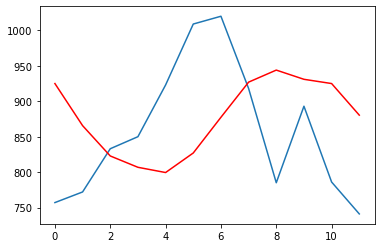

District: 7
Actuals: [609, 579, 593, 528, 611, 615, 735, 627, 658, 637, 666, 620]
Predictions: [674.4, 651.6, 634.4, 609.8, 600.0, 584.0, 585.2, 616.4, 623.2, 649.2, 654.4, 664.6]


District: 8
Actuals: [650, 575, 593, 652, 880, 820, 916, 903, 899, 891, 785, 800]
Predictions: [762.0, 721.8, 668.8, 636.8, 634.6, 670.0, 704.0, 772.2, 834.2, 883.6, 885.8, 878.8]


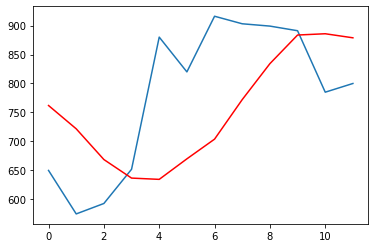

District: 9
Actuals: [1199, 1042, 1192, 1173, 1445, 1437, 1451, 1508, 1347, 1413, 1239, 1246]
Predictions: [1352.2, 1310.0, 1256.4, 1213.0, 1183.2, 1210.2, 1257.8, 1339.6, 1402.8, 1437.6, 1431.2, 1391.6]


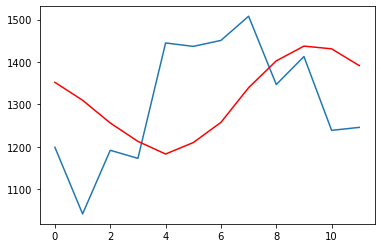

District: 10
Actuals: [1076, 980, 1015, 972, 1281, 1180, 1228, 1290, 1136, 1140, 1078, 978]
Predictions: [1220.4, 1164.2, 1103.2, 1064.6, 1028.4, 1064.8, 1085.6, 1135.2, 1190.2, 1223.0, 1194.8, 1174.4]


District: 11
Actuals: [860, 771, 954, 853, 976, 1013, 1046, 1055, 994, 1019, 925, 787]
Predictions: [946.8, 906.4, 866.4, 861.6, 858.2, 882.8, 913.4, 968.4, 988.6, 1016.8, 1025.4, 1007.8]


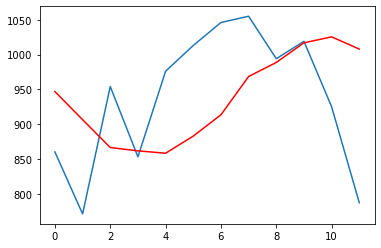

District: 12
Actuals: [1274, 1153, 1397, 1298, 1461, 1539, 1521, 1507, 1470, 1400, 1288, 1147]
Predictions: [1467.2, 1394.0, 1326.8, 1294.2, 1294.8, 1316.6, 1369.6, 1443.2, 1465.2, 1499.6, 1487.4, 1437.2]


District: 13
Actuals: [944, 805, 886, 924, 1090, 1085, 1188, 1206, 1215, 1152, 1156, 963]
Predictions: [1024.8, 985.8, 935.6, 912.6, 921.0, 929.8, 958.0, 1034.6, 1098.6, 1156.8, 1169.2, 1183.4]


District: 14
Actuals: [739, 605, 725, 691, 857, 943, 1016, 1021, 912, 1029, 860, 777]
Predictions: [893.2, 859.0, 787.0, 735.0, 709.0, 723.4, 764.2, 846.4, 905.6, 949.8, 984.2, 967.6]


District: 15
Actuals: [986, 818, 881, 869, 1096, 1025, 1212, 1086, 1102, 1035, 984, 984]
Predictions: [1011.6, 981.8, 951.2, 927.8, 918.2, 930.0, 937.8, 1016.6, 1057.6, 1104.2, 1092.0, 1083.8]


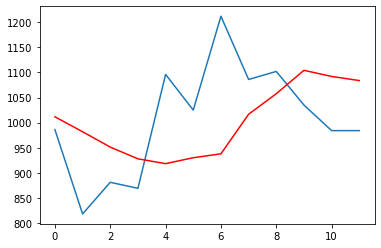

District: 16
Actuals: [540, 558, 550, 527, 603, 577, 561, 693, 610, 631, 588, 556]
Predictions: [632.0, 614.0, 594.0, 572.4, 564.4, 555.6, 563.0, 563.6, 592.2, 608.8, 614.4, 616.6]


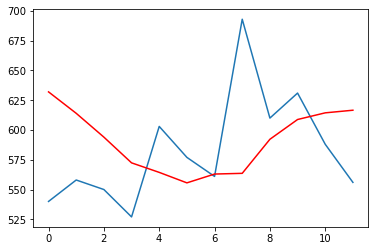

District: 17
Actuals: [693, 649, 725, 771, 974, 937, 1032, 1021, 955, 948, 887, 765]
Predictions: [874.2, 803.0, 751.6, 722.6, 720.2, 762.4, 811.2, 887.8, 947.0, 983.8, 978.6, 968.6]


District: 18
Actuals: [893, 755, 836, 875, 998, 1030, 1086, 1069, 1080, 986, 894, 833]
Predictions: [986.0, 943.0, 886.0, 853.6, 849.0, 871.4, 898.8, 965.0, 1011.6, 1052.6, 1050.2, 1023.0]


District: 19
Actuals: [1117, 971, 1165, 1132, 1315, 1295, 1394, 1361, 1215, 1418, 1179, 1110]
Predictions: [1294.8, 1243.2, 1161.0, 1136.2, 1120.0, 1140.0, 1175.6, 1260.2, 1299.4, 1316.0, 1336.6, 1313.4]


District: 20
Actuals: [1074, 922, 983, 1008, 1190, 1187, 1162, 1224, 1157, 1140, 1056, 1042]
Predictions: [1182.6, 1141.0, 1092.8, 1037.6, 1015.8, 1035.4, 1058.0, 1106.0, 1154.2, 1184.0, 1174.0, 1147.8]


District: 21
Actuals: [809, 701, 877, 888, 1030, 1040, 1026, 1053, 984, 998, 913, 813]
Predictions: [1062.2, 977.2, 895.2, 868.6, 856.0, 861.0, 907.2, 972.2, 1007.4, 1026.6, 1020.2, 994.8]


District: 22
Actuals: [505, 417, 526, 529, 560, 595, 578, 604, 573, 598, 554, 489]
Predictions: [576.8, 555.2, 519.8, 506.2, 504.0, 507.4, 525.4, 557.6, 573.2, 582.0, 589.6, 581.4]


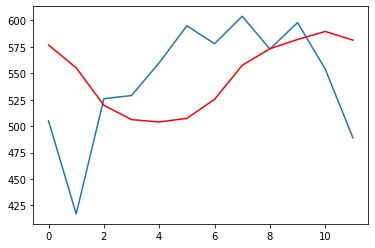

District: 23
Actuals: [1, 1]
Predictions: [2.2, 2.0]


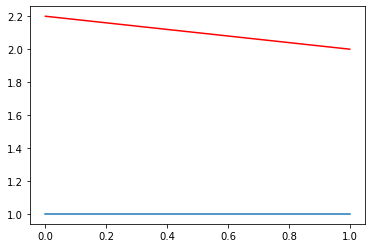

District: 24
Actuals: []
Predictions: []


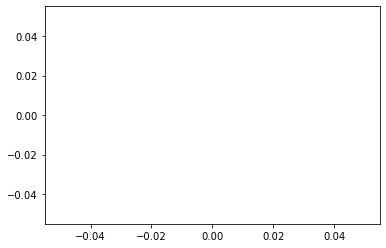

Test RMSE: 129.699


In [37]:
# prepare situation
window = 5
predTot = list()
testTot = list()
# walk forward over time steps in test
for distNum in range(len(train_d)):
    
    history = train_d[distNum]
    test = test_d[distNum]
    preds = []
    for t in range(len(test)):
        length = len(history)
        yhat = mean([history[i] for i in range(length - window, length)])
        obs = test[t]
        preds.append(yhat)
        history.append(obs)
    
    print('District: {}'.format(distNum+1))
    print('Actuals: {}'.format(test))
    print('Predictions: {}'.format(preds))
    # plot
    plt.plot(test)
    plt.plot(preds, color='red')
    plt.show()
    
    testTot = testTot + test
    predTot = predTot + preds
error = mean_squared_error(predTot, testTot) ** .5
print('Test RMSE: %.3f' % error)


## Weighted Moving Average

District: 1
Actuals: [958, 849, 1043, 1010, 1206, 1200, 1173, 1159, 1116, 1013, 887, 888]
Predictions: [961.2, 943.0, 901.8666666666667, 943.2, 971.5333333333333, 1057.0, 1119.2666666666667, 1156.4, 1167.2666666666667, 1156.0666666666666, 1103.4666666666667, 1021.7333333333333]


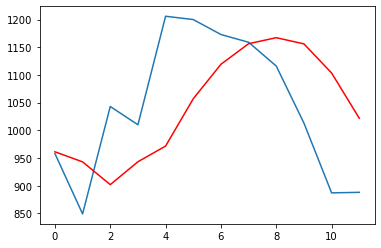

District: 2
Actuals: [836, 647, 814, 869, 922, 1060, 967, 996, 1048, 1073, 895, 725]
Predictions: [901.0666666666667, 863.9333333333333, 774.4666666666667, 767.4, 795.9333333333333, 843.8666666666667, 924.6666666666666, 959.5333333333333, 982.7333333333333, 1011.1333333333333, 1035.9333333333334, 991.3333333333334]


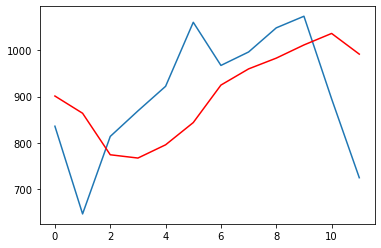

District: 3
Actuals: [282, 272, 314, 310, 300, 370, 354, 356, 333, 379, 317, 300]
Predictions: [328.46666666666664, 310.1333333333333, 293.4, 294.73333333333335, 299.06666666666666, 300.53333333333336, 325.3333333333333, 338.93333333333334, 347.73333333333335, 346.06666666666666, 358.2, 344.4]


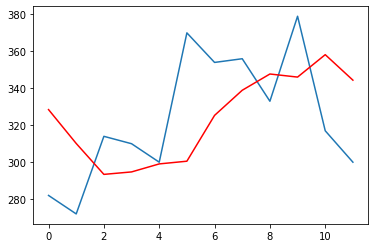

District: 4
Actuals: [568, 575, 608, 552, 673, 676, 706, 707, 675, 695, 686, 574]
Predictions: [650.4, 617.2666666666667, 595.7333333333333, 591.8666666666667, 575.1333333333333, 607.6666666666666, 634.6, 664.3333333333334, 685.6666666666666, 689.7333333333333, 692.2666666666667, 690.3333333333334]


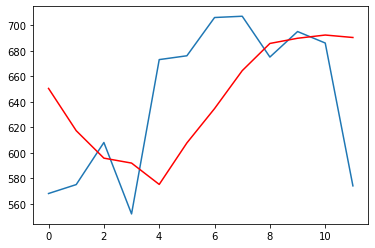

District: 5
Actuals: [882, 808, 848, 791, 999, 1070, 1077, 1122, 1092, 1036, 961, 1067]
Predictions: [1039.5333333333333, 981.6666666666666, 915.1333333333333, 880.8666666666667, 840.1333333333333, 880.0666666666667, 948.2, 1006.1333333333333, 1061.1333333333334, 1087.8666666666666, 1075.8666666666666, 1036.4]


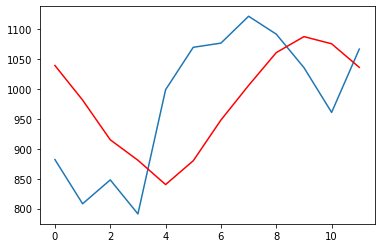

District: 6
Actuals: [757, 772, 833, 850, 923, 1009, 1020, 918, 785, 893, 786, 741]
Predictions: [801.0666666666667, 778.5333333333333, 771.7333333333333, 786.1333333333333, 810.2, 854.3333333333334, 915.0, 962.5333333333333, 959.5333333333333, 906.5333333333333, 893.8666666666667, 847.5333333333333]


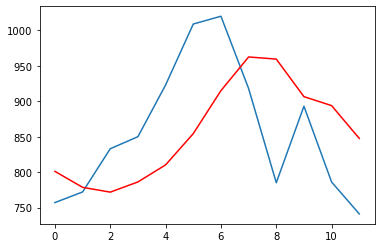

District: 7
Actuals: [609, 579, 593, 528, 611, 615, 735, 627, 658, 637, 666, 620]
Predictions: [641.2, 630.3333333333334, 610.6666666666666, 600.9333333333333, 572.4666666666667, 580.8666666666667, 591.2, 641.1333333333333, 644.6666666666666, 656.2666666666667, 652.2, 656.0666666666667]


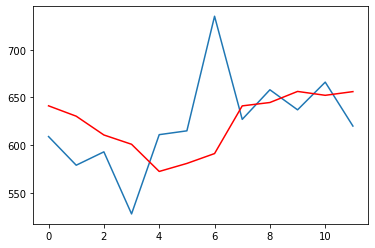

District: 8
Actuals: [650, 575, 593, 652, 880, 820, 916, 903, 899, 891, 785, 800]
Predictions: [834.2666666666667, 765.7333333333333, 689.0666666666667, 640.0, 630.4666666666667, 705.8, 755.8, 826.4666666666667, 870.0666666666667, 891.6666666666666, 894.1333333333333, 860.5333333333333]


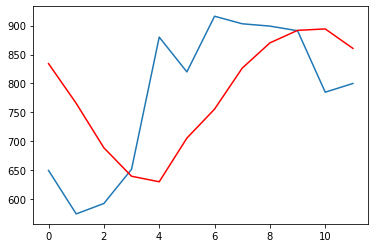

District: 9
Actuals: [1199, 1042, 1192, 1173, 1445, 1437, 1451, 1508, 1347, 1413, 1239, 1246]
Predictions: [1308.4666666666667, 1257.9333333333334, 1175.6666666666667, 1163.7333333333333, 1160.2, 1251.7333333333333, 1327.3333333333333, 1391.7333333333333, 1447.8666666666666, 1429.2666666666667, 1421.0666666666666, 1357.0]


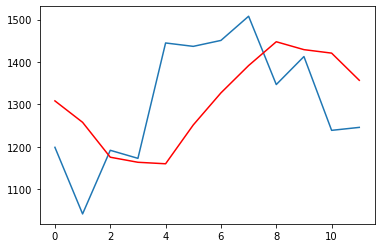

District: 10
Actuals: [1076, 980, 1015, 972, 1281, 1180, 1228, 1290, 1136, 1140, 1078, 978]
Predictions: [1078.9333333333334, 1062.8, 1028.9333333333334, 1017.1333333333333, 999.3333333333334, 1091.6, 1130.0, 1177.4666666666667, 1229.0666666666666, 1211.0, 1183.3333333333333, 1144.4]


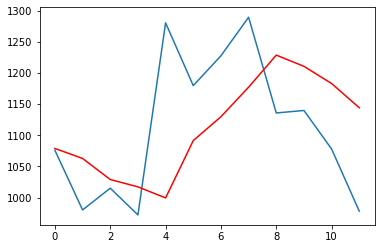

District: 11
Actuals: [860, 771, 954, 853, 976, 1013, 1046, 1055, 994, 1019, 925, 787]
Predictions: [915.6666666666666, 883.6666666666666, 835.0, 862.2, 860.0666666666667, 903.7333333333333, 947.1333333333333, 991.3333333333334, 1020.2, 1022.0, 1022.7333333333333, 989.2666666666667]


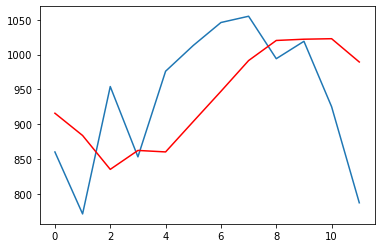

District: 12
Actuals: [1274, 1153, 1397, 1298, 1461, 1539, 1521, 1507, 1470, 1400, 1288, 1147]
Predictions: [1302.2666666666667, 1272.8, 1218.5333333333333, 1266.7333333333333, 1282.1333333333334, 1351.2, 1425.3333333333333, 1475.8, 1497.0666666666666, 1498.6666666666667, 1465.4666666666667, 1399.0]


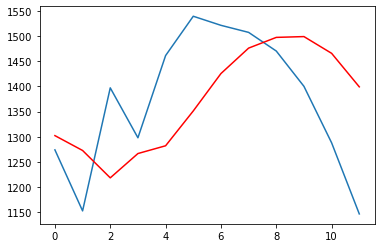

District: 13
Actuals: [944, 805, 886, 924, 1090, 1085, 1188, 1206, 1215, 1152, 1156, 963]
Predictions: [1102.0666666666666, 1037.2666666666667, 943.6, 904.2666666666667, 895.3333333333334, 957.2, 1008.9333333333333, 1085.6, 1142.7333333333333, 1181.5333333333333, 1179.9333333333334, 1175.5333333333333]


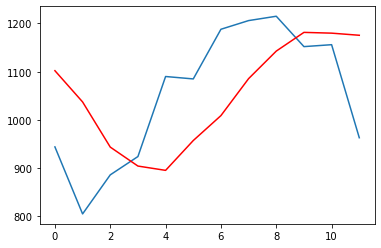

District: 14
Actuals: [739, 605, 725, 691, 857, 943, 1016, 1021, 912, 1029, 860, 777]
Predictions: [883.8, 823.5333333333333, 737.4, 711.7333333333333, 695.0, 744.8666666666667, 818.0666666666667, 902.0, 960.2, 962.3333333333334, 988.7333333333333, 947.3333333333334]


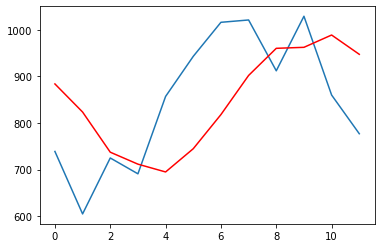

District: 15
Actuals: [986, 818, 881, 869, 1096, 1025, 1212, 1086, 1102, 1035, 984, 984]
Predictions: [1016.7333333333333, 999.3333333333334, 932.6, 905.8, 885.2666666666667, 948.0666666666667, 979.7333333333333, 1071.1333333333334, 1094.2666666666667, 1109.0666666666666, 1086.0, 1050.0]


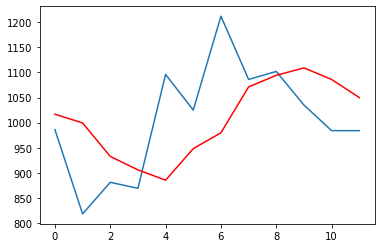

District: 16
Actuals: [540, 558, 550, 527, 603, 577, 561, 693, 610, 631, 588, 556]
Predictions: [595.8666666666667, 570.6666666666666, 561.6666666666666, 553.4666666666667, 543.0, 561.9333333333333, 569.0666666666667, 568.4, 611.5333333333333, 617.4666666666667, 624.8666666666667, 616.0666666666667]


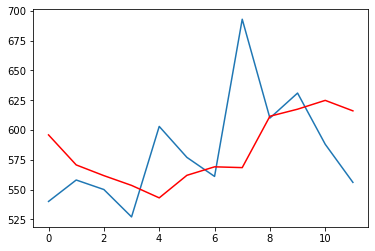

District: 17
Actuals: [693, 649, 725, 771, 974, 937, 1032, 1021, 955, 948, 887, 765]
Predictions: [876.5333333333333, 802.4666666666667, 735.6, 714.4666666666667, 723.5333333333333, 808.0, 866.2, 939.8, 984.2, 986.8666666666667, 974.9333333333333, 944.4]


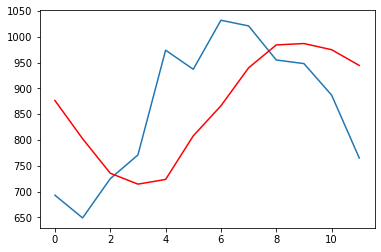

District: 18
Actuals: [893, 755, 836, 875, 998, 1030, 1086, 1069, 1080, 986, 894, 833]
Predictions: [928.5333333333333, 902.0666666666667, 841.3333333333334, 829.2666666666667, 840.2, 893.4, 946.2666666666667, 1008.6666666666666, 1043.3333333333333, 1066.1333333333334, 1043.9333333333334, 991.8666666666667]


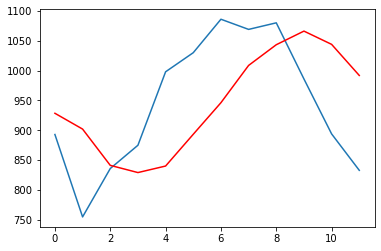

District: 19
Actuals: [1117, 971, 1165, 1132, 1315, 1295, 1394, 1361, 1215, 1418, 1179, 1110]
Predictions: [1220.7333333333333, 1174.2, 1095.2666666666667, 1097.2666666666667, 1105.1333333333334, 1177.1333333333334, 1228.8, 1301.6, 1335.2, 1307.0666666666666, 1341.0666666666666, 1288.5333333333333]


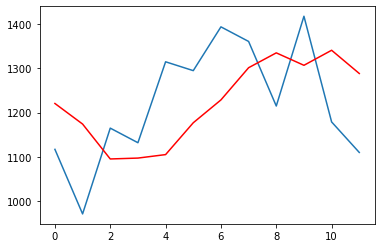

District: 20
Actuals: [1074, 922, 983, 1008, 1190, 1187, 1162, 1224, 1157, 1140, 1056, 1042]
Predictions: [1092.8, 1076.2, 1018.9333333333333, 997.6666666666666, 995.2, 1056.6, 1107.1333333333334, 1141.8, 1181.1333333333334, 1182.0666666666666, 1167.4, 1128.0666666666666]


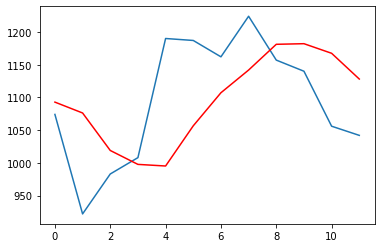

District: 21
Actuals: [809, 701, 877, 888, 1030, 1040, 1026, 1053, 984, 998, 913, 813]
Predictions: [915.4666666666667, 867.7333333333333, 800.2666666666667, 810.3333333333334, 832.1333333333333, 902.9333333333333, 962.6, 1002.2, 1029.1333333333334, 1021.3333333333334, 1011.8, 976.0666666666667]


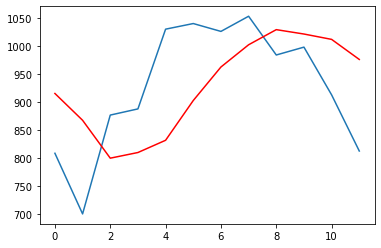

District: 22
Actuals: [505, 417, 526, 529, 560, 595, 578, 604, 573, 598, 554, 489]
Predictions: [547.0, 527.4666666666667, 485.2, 489.6666666666667, 499.93333333333334, 522.2, 551.4, 568.9333333333333, 584.4, 584.3333333333334, 589.6666666666666, 577.8]


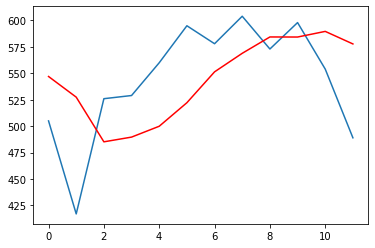

District: 23
Actuals: [1, 1]
Predictions: [1.2666666666666666, 1.1333333333333333]


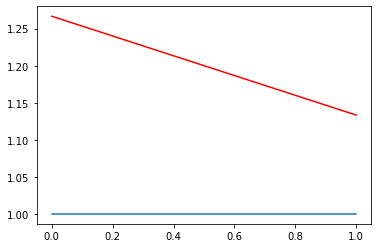

District: 24
Actuals: []
Predictions: []


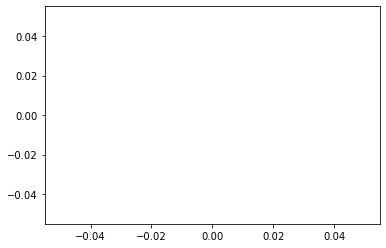

Test RMSE: 112.446


In [39]:
# prepare situation
window = 5
predTot = list()
testTot = list()
# walk forward over time steps in test
for distNum in range(len(train_d)):
    
    history = train_d[distNum]
    test = test_d[distNum]
    preds = []
    for t in range(len(test)):
        length = len(history)
        yhat = np.average([history[i] for i in range(length - window, length)], weights=[1,2,3,4,5])
        obs = test[t]
        preds.append(yhat)
        history.append(obs)
    
    print('District: {}'.format(distNum+1))
    print('Actuals: {}'.format(test))
    print('Predictions: {}'.format(preds))
    # plot
    plt.plot(test)
    plt.plot(preds, color='red')
    plt.show()
    
    testTot = testTot + test
    predTot = predTot + preds
error = mean_squared_error(predTot, testTot) ** .5
print('Test RMSE: %.3f' % error)

## Exponential Moving Average

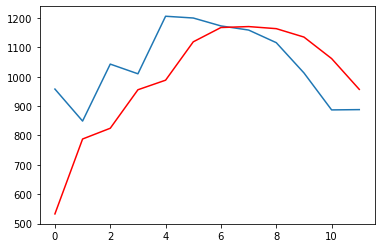

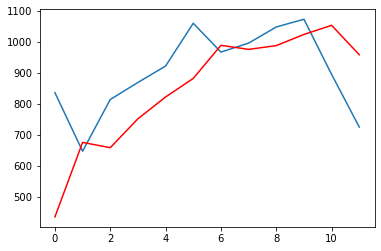

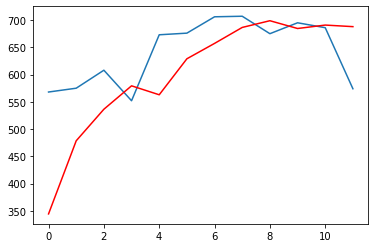

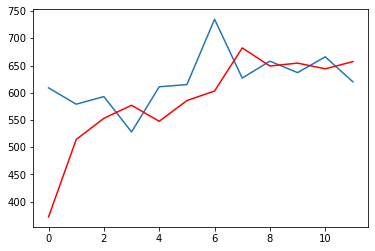

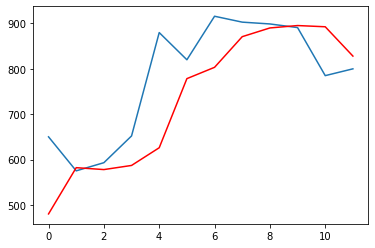

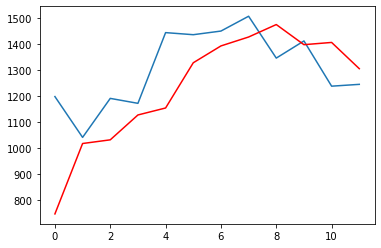

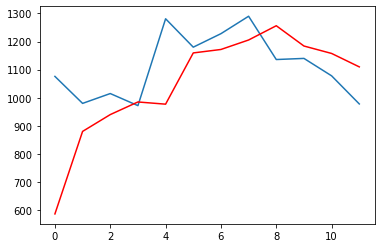

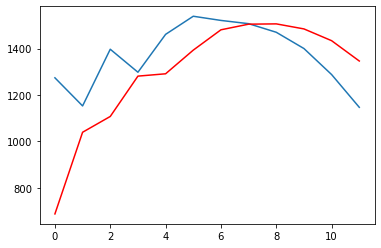

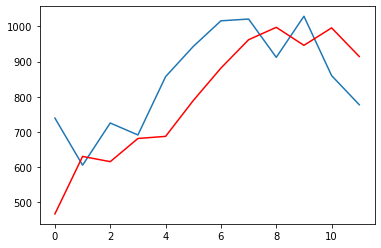

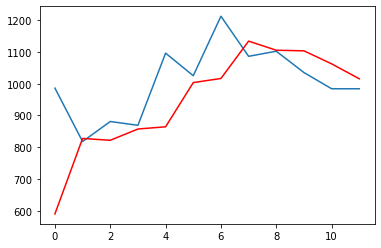

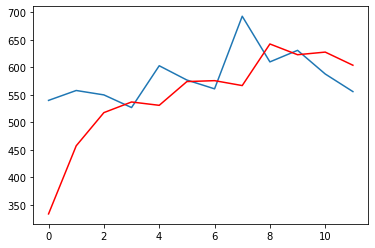

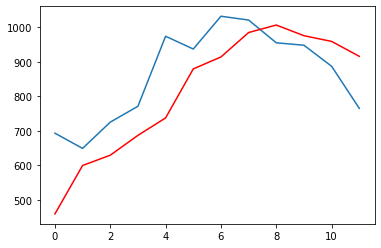

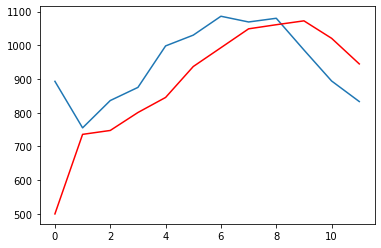

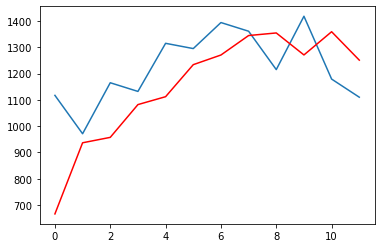

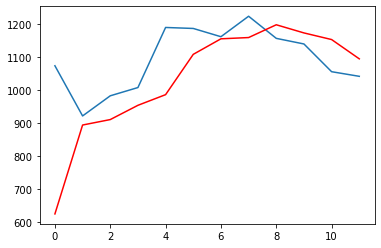

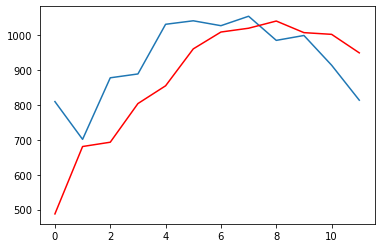

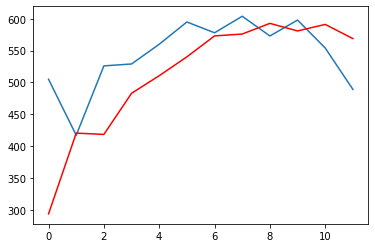

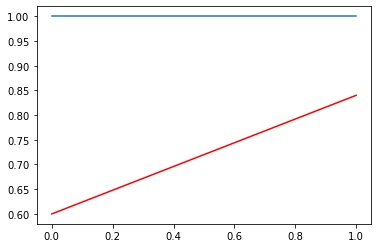

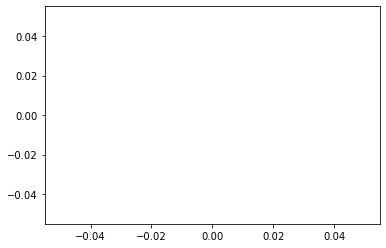

Test RMSE: 139.679


In [40]:
# prepare situation
predTot = list()
testTot = list()
alpha = 0.6
# walk forward over time steps in test
for distNum in range(len(train_d)):
    
    history = train_d[distNum]
    test = test_d[distNum]
    preds = []
    lastPred = 0
    for t in range(len(test)):
        yhat = ((1-alpha)*lastPred + (alpha*history[-1]))
        lastPred = yhat
        obs = test[t]
        preds.append(yhat)
        history.append(obs)
        
    # plot
    plt.plot(test)
    plt.plot(preds, color='red')
    plt.show()
    
    testTot = testTot + test
    predTot = predTot + preds
error = mean_squared_error(predTot, testTot) ** .5
print('Test RMSE: %.3f' % error)

## 1-layer LSTM based approach

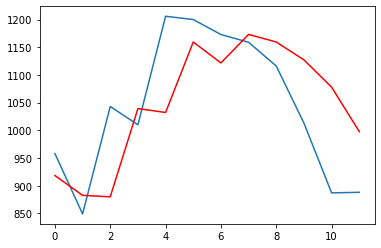

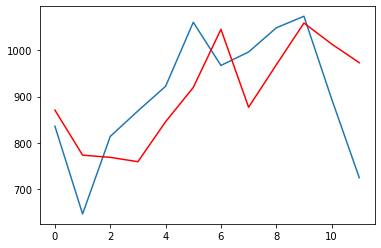

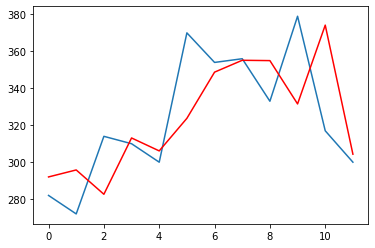

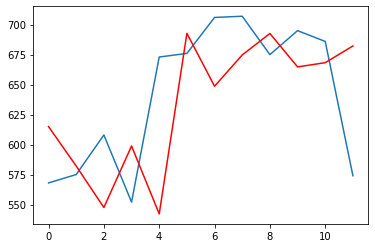

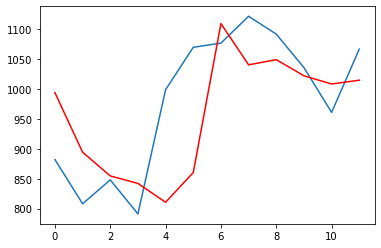

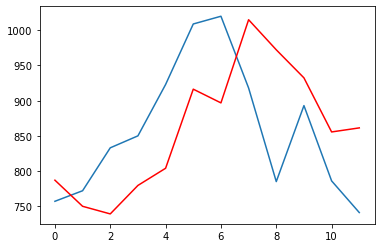

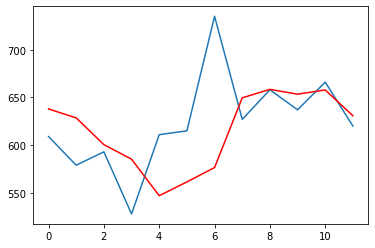

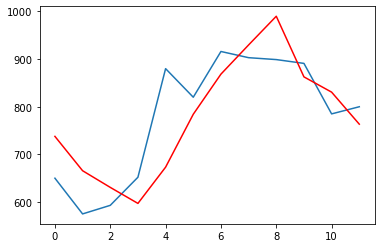

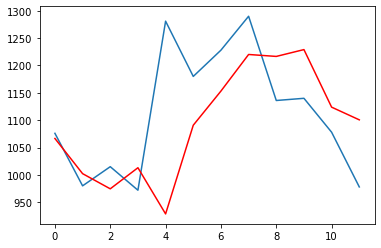

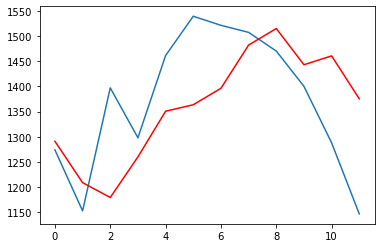

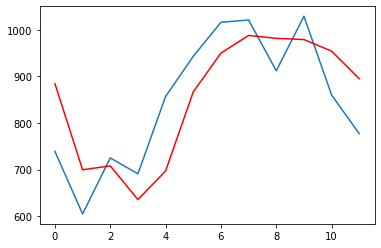

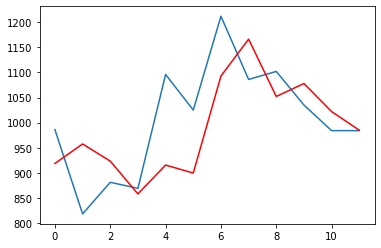

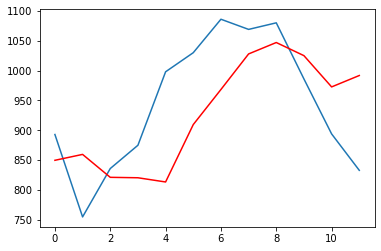

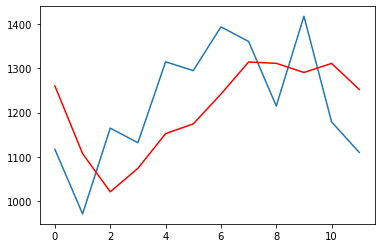

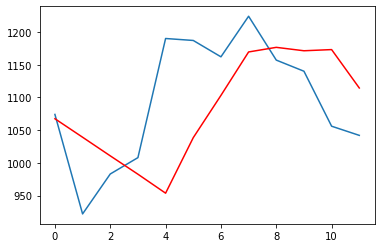

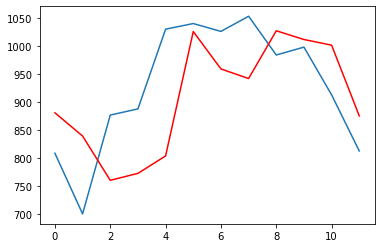

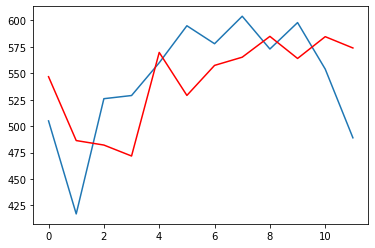

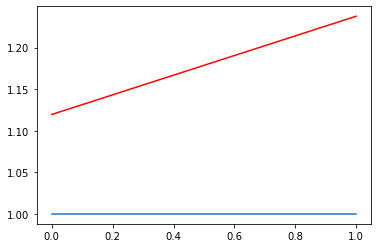

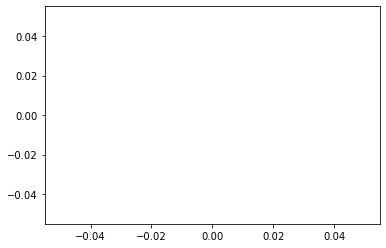


Test RMSE: 97.383


In [41]:
# prepare situation
window = 3
predTot = list()
testTot = list()

# walk forward over time steps in test
for distNum in tqdm_notebook(range(len(train_d))):
    
    history = train_d[distNum]
    test = test_d[distNum]
    preds = []
    for t in tqdm_notebook(range(len(test)), leave=False):
        
        length = len(history)
        
        # split into samples
        X, y = split_sequence(history, window)
        
        # reshape from [samples, timesteps] into [samples, timesteps, features]
        n_features = 1
        X = X.reshape((X.shape[0], X.shape[1], n_features))
        
        # define model
        model = Sequential()
        model.add(LSTM(50, activation='relu', input_shape=(window, n_features)))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mse')
        
        # fit model
        model.fit(X, y, epochs=200, verbose=0)
        
        X_test = array([history[i] for i in range(length-window, length)])
        X_test = X_test.reshape((1, window, n_features))
        yhat = model.predict(X_test, verbose=0)
        
        obs = test[t]
        preds.append(yhat.reshape((1,)))
        history.append(obs)
        
    # plot
    plt.plot(test)
    plt.plot(preds, color='red')
    plt.show()
    
    testTot = testTot + test
    predTot = predTot + preds
error = mean_squared_error(predTot, testTot) ** .5
print('Test RMSE: %.3f' % error)

## Bidirectional LSTM Based approach

District: 1
Actuals: [958, 849, 1043, 1010, 1206, 1200, 1173, 1159, 1116, 1013, 887, 888]
Predictions: [870.9181, 877.1724, 874.88165, 1016.444, 1052.7329, 1095.5659, 1117.7717, 1144.0443, 1137.0414, 1071.6433, 1042.7695, 976.9115]


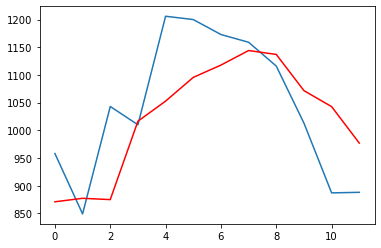

District: 2
Actuals: [836, 647, 814, 869, 922, 1060, 967, 996, 1048, 1073, 895, 725]
Predictions: [767.1409, 730.71484, 674.6193, 821.32404, 892.1607, 942.80566, 1024.9619, 973.1174, 909.8006, 1076.6349, 1011.33746, 908.1979]


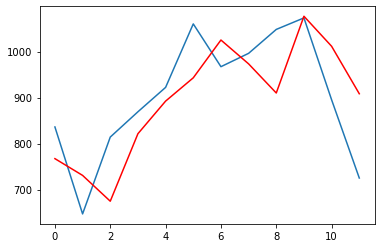

District: 3
Actuals: [282, 272, 314, 310, 300, 370, 354, 356, 333, 379, 317, 300]
Predictions: [299.98184, 308.99887, 294.26566, 323.49384, 300.32632, 307.59033, 345.57187, 357.46677, 336.52286, 327.0385, 359.86475, 318.46417]


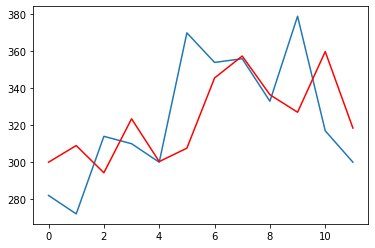

District: 4
Actuals: [568, 575, 608, 552, 673, 676, 706, 707, 675, 695, 686, 574]
Predictions: [599.111, 567.63086, 561.16394, 623.4034, 566.8267, 682.4262, 688.5232, 703.82764, 685.17755, 658.3131, 664.54694, 678.884]


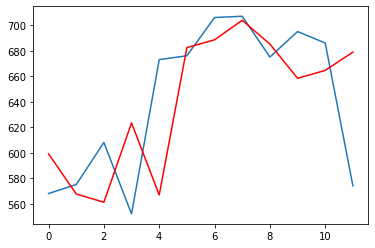

District: 5
Actuals: [882, 808, 848, 791, 999, 1070, 1077, 1122, 1092, 1036, 961, 1067]
Predictions: [987.8835, 928.2678, 892.03625, 838.8147, 807.26733, 923.7725, 1070.9178, 1059.7737, 1027.5818, 1046.1292, 1029.4238, 1023.7062]


District: 6
Actuals: [757, 772, 833, 850, 923, 1009, 1020, 918, 785, 893, 786, 741]
Predictions: [767.53827, 749.6863, 763.9716, 864.4748, 811.40375, 915.057, 956.56146, 1023.36017, 959.3431, 840.2066, 820.81885, 803.1264]


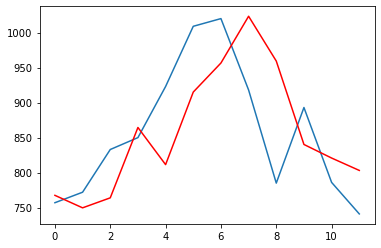

District: 7
Actuals: [609, 579, 593, 528, 611, 615, 735, 627, 658, 637, 666, 620]
Predictions: [634.1741, 606.72345, 588.62396, 577.83276, 555.42377, 559.4975, 581.89636, 659.25543, 722.1237, 666.2689, 628.1238, 640.48444]


District: 8
Actuals: [650, 575, 593, 652, 880, 820, 916, 903, 899, 891, 785, 800]
Predictions: [752.51117, 662.56616, 591.576, 575.95996, 609.90076, 798.6765, 901.3683, 947.34076, 927.8618, 813.40045, 838.5875, 785.43396]


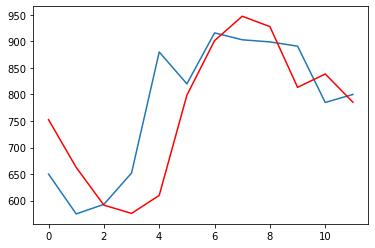

District: 9
Actuals: [1199, 1042, 1192, 1173, 1445, 1437, 1451, 1508, 1347, 1413, 1239, 1246]
Predictions: [1222.4603, 1169.533, 1088.7722, 1090.2467, 1216.0308, 1287.2211, 1438.4922, 1416.1617, 1444.2009, 1368.6896, 1404.1031, 1268.6012]


District: 10
Actuals: [1076, 980, 1015, 972, 1281, 1180, 1228, 1290, 1136, 1140, 1078, 978]
Predictions: [1005.5941, 1039.1874, 1050.5726, 973.16614, 953.73035, 1086.1172, 1231.5469, 1182.3292, 1171.9849, 1161.6965, 1157.2041, 1097.2129]


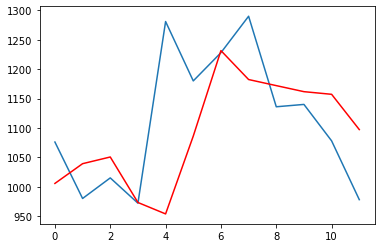

District: 11
Actuals: [860, 771, 954, 853, 976, 1013, 1046, 1055, 994, 1019, 925, 787]
Predictions: [851.9051, 835.3766, 797.84875, 891.19244, 865.2863, 886.2702, 1007.0997, 989.6949, 1046.2979, 996.1778, 974.5894, 942.0753]


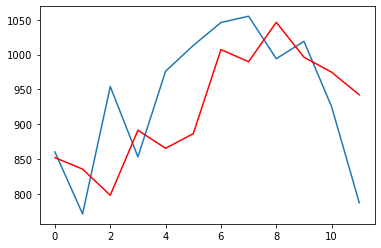

District: 12
Actuals: [1274, 1153, 1397, 1298, 1461, 1539, 1521, 1507, 1470, 1400, 1288, 1147]
Predictions: [1266.4478, 1286.0833, 1222.1262, 1340.7635, 1251.382, 1399.1761, 1435.6113, 1491.4677, 1516.2611, 1487.456, 1398.6593, 1366.5104]


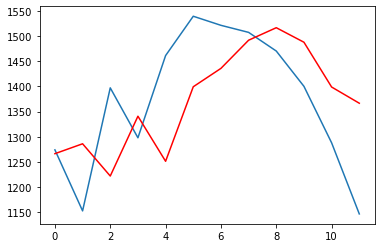

District: 13
Actuals: [944, 805, 886, 924, 1090, 1085, 1188, 1206, 1215, 1152, 1156, 963]
Predictions: [998.2118, 918.4776, 839.5748, 814.092, 884.76337, 1053.7142, 1173.6389, 1220.8668, 1192.2739, 1144.5764, 1095.7965, 1086.461]


District: 14
Actuals: [739, 605, 725, 691, 857, 943, 1016, 1021, 912, 1029, 860, 777]
Predictions: [800.30316, 726.1961, 641.3928, 704.3816, 714.89453, 884.7524, 846.0606, 1073.9436, 1037.9567, 907.8255, 980.7728, 852.71515]


District: 15
Actuals: [986, 818, 881, 869, 1096, 1025, 1212, 1086, 1102, 1035, 984, 984]
Predictions: [932.75555, 970.089, 860.914, 824.47565, 880.006, 1002.0427, 1115.1714, 1054.9564, 1217.9677, 1079.8102, 1011.12024, 992.85724]


District: 16
Actuals: [540, 558, 550, 527, 603, 577, 561, 693, 610, 631, 588, 556]
Predictions: [584.5162, 551.44617, 560.4758, 556.5884, 531.72095, 553.97394, 571.2612, 571.3215, 604.0658, 630.6155, 625.9743, 606.8264]


District: 17
Actuals: [693, 649, 725, 771, 974, 937, 1032, 1021, 955, 948, 887, 765]
Predictions: [805.5477, 680.07574, 688.9013, 736.538, 748.12177, 903.34735, 967.3088, 1018.8214, 1057.786, 941.6737, 920.867, 861.1527]


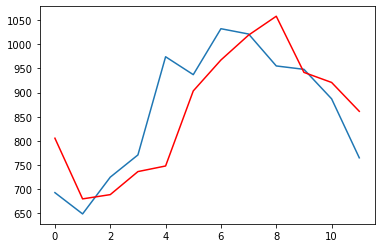

District: 18
Actuals: [893, 755, 836, 875, 998, 1030, 1086, 1069, 1080, 986, 894, 833]
Predictions: [847.521, 809.68994, 761.6427, 829.1755, 827.2875, 905.94165, 1018.1656, 1004.7844, 1097.0837, 998.2518, 1028.094, 943.3391]


District: 19
Actuals: [1117, 971, 1165, 1132, 1315, 1295, 1394, 1361, 1215, 1418, 1179, 1110]
Predictions: [1167.9875, 1094.213, 1054.4219, 1088.161, 1092.5493, 1177.9221, 1228.7125, 1328.1174, 1345.3407, 1282.8628, 1345.3308, 1218.4259]


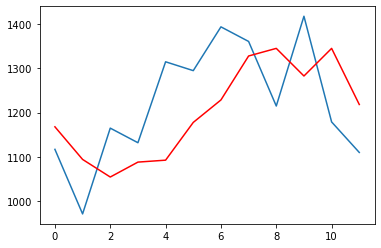

District: 20
Actuals: [1074, 922, 983, 1008, 1190, 1187, 1162, 1224, 1157, 1140, 1056, 1042]
Predictions: [1063.7505, 1075.2609, 990.19324, 993.14185, 957.0255, 1040.4736, 1106.9015, 1165.2003, 1170.8367, 1160.3938, 1154.534, 1082.1312]


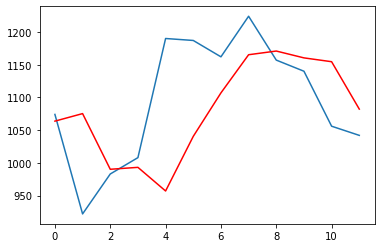

District: 21
Actuals: [809, 701, 877, 888, 1030, 1040, 1026, 1053, 984, 998, 913, 813]
Predictions: [801.5398, 802.55664, 710.69183, 926.1119, 826.07074, 984.05115, 1097.2177, 986.09595, 1014.0229, 997.25085, 960.3543, 857.7071]


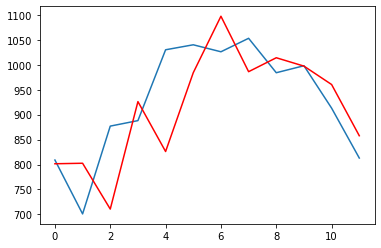

District: 22
Actuals: [505, 417, 526, 529, 560, 595, 578, 604, 573, 598, 554, 489]
Predictions: [500.83047, 466.20898, 530.875, 521.1291, 496.81332, 539.9044, 545.32355, 568.6603, 603.60474, 605.29913, 564.51874, 549.97253]


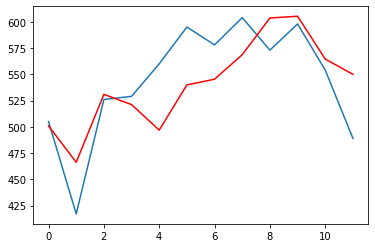

District: 23
Actuals: [1, 1]
Predictions: [1.2319714, 1.3084314]


District: 24
Actuals: []
Predictions: []


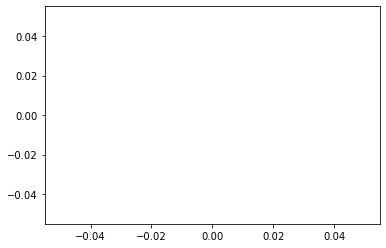


Test RMSE: 90.623


In [42]:
# prepare situation
window = 3
predTot = list()
testTot = list()

# walk forward over time steps in test
for distNum in tqdm_notebook(range(len(train_d))):
    
    history = train_d[distNum]
    test = test_d[distNum]
    preds = []
    for t in tqdm_notebook(range(len(test)), leave=False):
        
        length = len(history)
        
        # split into samples
        X, y = split_sequence(history, window)
        
        # reshape from [samples, timesteps] into [samples, timesteps, features]
        n_features = 1
        X = X.reshape((X.shape[0], X.shape[1], n_features))
        
        model = Sequential()
        model.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(window, n_features)))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mse')
        
        # fit model
        model.fit(X, y, epochs=200, verbose=0)
        
        X_test = array([history[i] for i in range(length-window, length)])
        X_test = X_test.reshape((1, window, n_features))
        yhat = model.predict(X_test, verbose=0)
        
        obs = test[t]
        preds.append(yhat.reshape((1,)))
        history.append(obs)
    
    preds_new = [i[0] for i in preds]
    print('District: {}'.format(distNum+1))
    print('Actuals: {}'.format(test))
    print('Predictions: {}'.format(preds_new))
    
    # plot
    plt.plot(test)
    plt.plot(preds_new, color='red')
    plt.show()
    
    testTot = testTot + test
    predTot = predTot + preds_new
error = mean_squared_error(predTot, testTot) ** .5
print('Test RMSE: %.3f' % error)

## CNN - LSTM based approach

District: 1
Actuals: [958, 849, 1043, 1010, 1206, 1200, 1173, 1159, 1116, 1013, 887, 888]
Predictions: [770.7626, 886.79944, 918.39966, 990.37885, 1007.1264, 1168.7539, 1194.0863, 1138.8953, 1100.497, 1095.9751, 1032.8988, 930.87256]


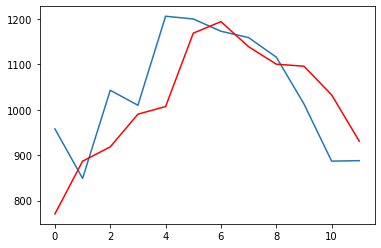

District: 2
Actuals: [836, 647, 814, 869, 922, 1060, 967, 996, 1048, 1073, 895, 725]
Predictions: [766.40796, 717.70123, 801.56116, 750.3552, 834.5781, 887.1682, 1029.0702, 1026.6495, 1.9981228, 1012.2959, 1036.8856, 1000.93085]


District: 3
Actuals: [282, 272, 314, 310, 300, 370, 354, 356, 333, 379, 317, 300]
Predictions: [297.42447, 271.18878, 264.99747, 300.79266, 295.08615, 289.9132, 340.522, 336.35205, 355.52115, 340.20938, 363.43323, 363.4468]


District: 4
Actuals: [568, 575, 608, 552, 673, 676, 706, 707, 675, 695, 686, 574]
Predictions: [617.0285, 532.78265, 541.49084, 601.0222, 593.069, 647.0538, 671.15283, 709.037, 697.1291, 678.5546, 632.902, 649.00586]


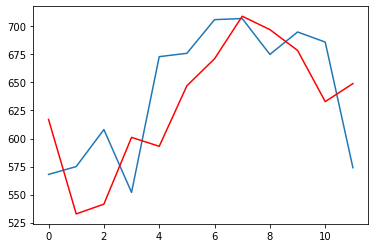

District: 5
Actuals: [882, 808, 848, 791, 999, 1070, 1077, 1122, 1092, 1036, 961, 1067]
Predictions: [1023.8077, 1008.4408, 794.31836, 790.12756, 813.6762, 967.72064, 1055.404, 1039.1439, 1071.434, 1043.0868, 1047.8751, 965.30145]


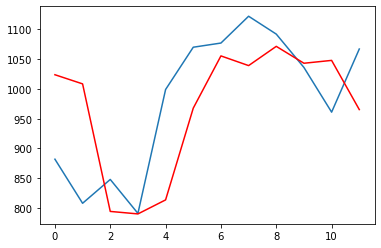

District: 6
Actuals: [757, 772, 833, 850, 923, 1009, 1020, 918, 785, 893, 786, 741]
Predictions: [734.3468, 716.1786, 707.2188, 818.6602, 835.8635, 897.05927, 984.4578, 1008.61035, 916.16125, 857.9904, 834.429, 854.63983]


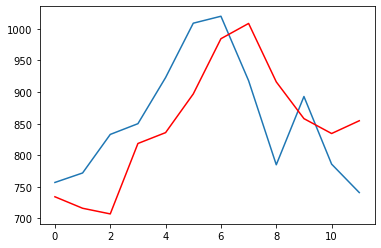

District: 7
Actuals: [609, 579, 593, 528, 611, 615, 735, 627, 658, 637, 666, 620]
Predictions: [642.2014, 591.1346, 582.54266, 560.70795, 576.0017, 585.3817, 605.4686, 675.54266, 659.69794, 646.04865, 630.4848, 631.46747]


District: 8
Actuals: [650, 575, 593, 652, 880, 820, 916, 903, 899, 891, 785, 800]
Predictions: [733.75555, 767.9611, 608.4447, 526.624, 622.04944, 891.6897, 863.5497, 876.7404, 932.6734, 848.1377, 769.228, 829.2756]


District: 9
Actuals: [1199, 1042, 1192, 1173, 1445, 1437, 1451, 1508, 1347, 1413, 1239, 1246]
Predictions: [1221.4746, 1128.0269, 1153.6428, 1120.852, 1140.7655, 1380.4783, 1311.108, 1401.697, 1487.2006, 1471.817, 1364.3488, 1340.1403]


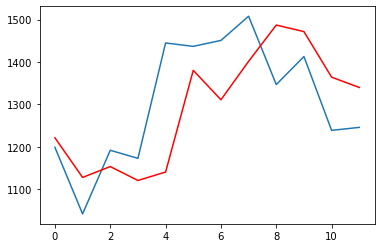

District: 10
Actuals: [1076, 980, 1015, 972, 1281, 1180, 1228, 1290, 1136, 1140, 1078, 978]
Predictions: [998.36914, 1002.36273, 1024.9899, 969.1959, 958.1289, 1224.3718, 1222.8683, 1184.5139, 1232.755, 1251.7686, 1085.8939, 1081.1151]


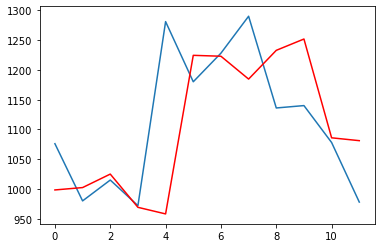

District: 11
Actuals: [860, 771, 954, 853, 976, 1013, 1046, 1055, 994, 1019, 925, 787]
Predictions: [900.46375, 779.0182, 803.54175, 886.38165, 892.28925, 963.4946, 972.35175, 1009.3304, 1014.0795, 1.9979293, 984.33905, 996.5018]


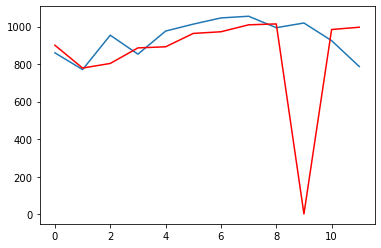

District: 12
Actuals: [1274, 1153, 1397, 1298, 1461, 1539, 1521, 1507, 1470, 1400, 1288, 1147]
Predictions: [1214.4904, 1254.5216, 1230.7571, 1346.8022, 1306.8433, 1398.9445, 1415.5731, 1487.7272, 1468.8992, 1458.8042, 1417.068, 1391.4498]


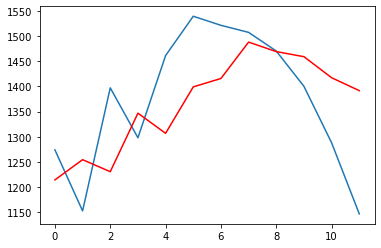

District: 13
Actuals: [944, 805, 886, 924, 1090, 1085, 1188, 1206, 1215, 1152, 1156, 963]
Predictions: [1077.671, 867.0579, 934.85785, 831.6491, 887.3144, 1084.3905, 1049.0814, 1159.9556, 1209.1586, 1104.1329, 1164.615, 1074.036]


District: 14
Actuals: [739, 605, 725, 691, 857, 943, 1016, 1021, 912, 1029, 860, 777]
Predictions: [754.51044, 725.31464, 656.0987, 662.44617, 680.46576, 845.8489, 972.2239, 1051.5492, 979.5794, 910.41895, 918.696, 970.35284]


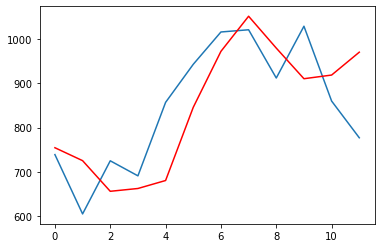

District: 15
Actuals: [986, 818, 881, 869, 1096, 1025, 1212, 1086, 1102, 1035, 984, 984]
Predictions: [940.9439, 966.53674, 927.9435, 834.3441, 849.37366, 1020.8872, 1055.7587, 1118.5657, 1170.2993, 1089.9026, 1054.6642, 985.64954]


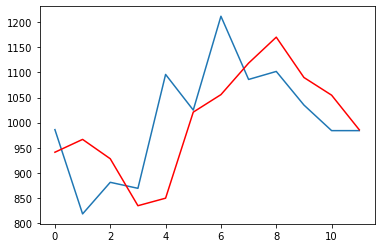

District: 16
Actuals: [540, 558, 550, 527, 603, 577, 561, 693, 610, 631, 588, 556]
Predictions: [577.11224, 539.36316, 544.95135, 536.3813, 525.24164, 572.7081, 562.67834, 554.41425, 635.2131, 620.0875, 621.8617, 614.6376]


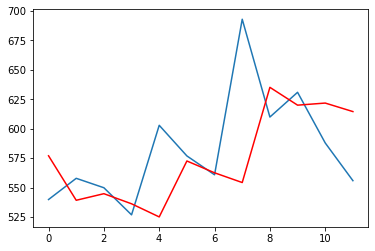

District: 17
Actuals: [693, 649, 725, 771, 974, 937, 1032, 1021, 955, 948, 887, 765]
Predictions: [818.8449, 735.9325, 596.35065, 681.69336, 757.9237, 965.66626, 939.17255, 983.1763, 1002.8273, 933.21246, 888.93854, 871.0042]


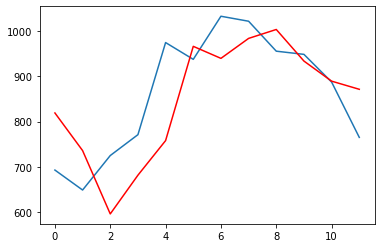

District: 18
Actuals: [893, 755, 836, 875, 998, 1030, 1086, 1069, 1080, 986, 894, 833]
Predictions: [809.9326, 867.8271, 865.62714, 794.7092, 827.89954, 987.5702, 1039.606, 1018.38214, 1073.7612, 1077.6439, 1033.9452, 942.4527]


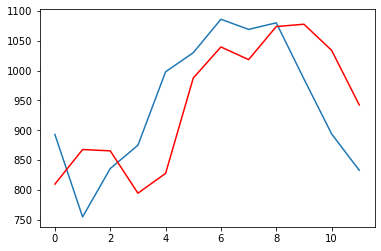

District: 19
Actuals: [1117, 971, 1165, 1132, 1315, 1295, 1394, 1361, 1215, 1418, 1179, 1110]
Predictions: [1085.0039, 1110.796, 1059.2338, 1105.8293, 1101.3546, 1256.7642, 1264.9177, 1314.1548, 1326.4972, 1309.0071, 1356.8881, 1355.5221]


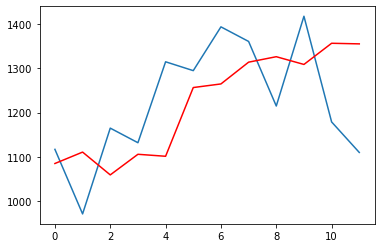

District: 20
Actuals: [1074, 922, 983, 1008, 1190, 1187, 1162, 1224, 1157, 1140, 1056, 1042]
Predictions: [1060.84, 1050.8254, 1029.6176, 973.9937, 967.7132, 1113.2969, 1115.7546, 1145.0265, 1180.3413, 1167.67, 1115.5287, 1105.7761]


District: 21
Actuals: [809, 701, 877, 888, 1030, 1040, 1026, 1053, 984, 998, 913, 813]
Predictions: [851.0112, 721.66815, 733.436, 848.54803, 855.7306, 1006.6062, 1027.6575, 982.26154, 1005.87317, 999.83636, 934.8775, 949.5093]


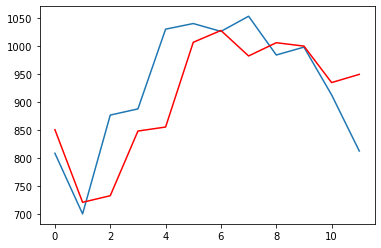

District: 22
Actuals: [505, 417, 526, 529, 560, 595, 578, 604, 573, 598, 554, 489]
Predictions: [499.5773, 470.03113, 499.7829, 503.74014, 503.91852, 542.5329, 604.4102, 571.1897, 554.41187, 578.35406, 552.40186, 545.121]


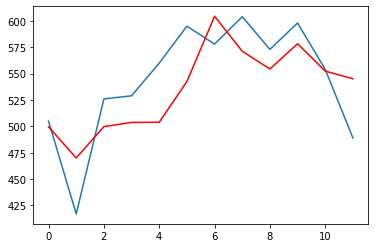

District: 23
Actuals: [1, 1]
Predictions: [1.0703449, 0.9999534]


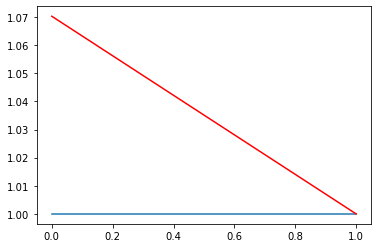

District: 24
Actuals: []
Predictions: []


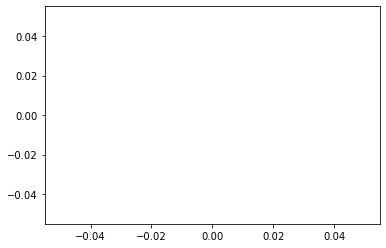


Test RMSE: 129.716


In [44]:
# prepare situation
window = 4
predTot = list()
testTot = list()

# walk forward over time steps in test
for distNum in tqdm_notebook(range(len(train_d))):
    
    history = train_d[distNum]
    test = test_d[distNum]
    preds = []
    for t in tqdm_notebook(range(len(test)), leave=False):
        
        length = len(history)
        
        # split into samples
        X, y = split_sequence(history, window)
        
        # reshape from [samples, timesteps] into [samples, subsequences, timesteps, features]
        n_features = 1
        n_seq = 2
        n_steps = 2
        X = X.reshape((X.shape[0], n_seq, n_steps, n_features))
        
        model = Sequential()
        model.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, n_steps, n_features)))
        model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
        model.add(TimeDistributed(Flatten()))
        model.add(LSTM(50, activation='relu'))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mse')
        
        # fit model
        model.fit(X, y, epochs=500, verbose=0)
        
        X_test = array([history[i] for i in range(length-window, length)])
        X_test = X_test.reshape((1, n_seq, n_steps, n_features))
        yhat = model.predict(X_test, verbose=0)
        
        obs = test[t]
        preds.append(yhat.reshape((1,)))
        history.append(obs)
    
    preds_new = [i[0] for i in preds]
    print('District: {}'.format(distNum+1))
    print('Actuals: {}'.format(test))
    print('Predictions: {}'.format(preds_new))
    
    # plot
    plt.plot(test)
    plt.plot(preds_new, color='red')
    plt.show()
    
    testTot = testTot + test
    predTot = predTot + preds_new
error = mean_squared_error(predTot, testTot) ** .5
print('Test RMSE: %.3f' % error)

In [46]:
x = PrettyTable()

x.field_names = ['Window', 'Method', 'Test RMSE']

x.add_row(['Month', 'Simple moving avg', '129.699'])
x.add_row(['Month', 'Weighted moving avg', '112.446'])
x.add_row(['Month', 'Exponential moving avg', '139.679'])
x.add_row(['Month', '1-layer LSTM', '97.383'])
x.add_row(['Month', 'Bidirectional LSTM', '90.623'])
x.add_row(['Month', 'CNN LSTM', '129.716'])

In [47]:
print(x)

+--------+------------------------+-----------+
| Window |         Method         | Test RMSE |
+--------+------------------------+-----------+
| Month  |   Simple moving avg    |  129.699  |
| Month  |  Weighted moving avg   |  112.446  |
| Month  | Exponential moving avg |  139.679  |
| Month  |      1-layer LSTM      |   97.383  |
| Month  |   Bidirectional LSTM   |   90.623  |
| Month  |        CNN LSTM        |  129.716  |
+--------+------------------------+-----------+
